In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')
# from sklearnex import patch_sklearn
#
# patch_sklearn()
# sklearnex.get_config()


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
# import sys
# sys.path.append("dataset_tool")
#
# from dataset_tool.dataset_loader import *

In [2]:
from glob import glob

S_sentinel_bands = glob("/tmp/shared/dataset_5/**/*B?*.tiff", recursive=True)
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B01_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B02_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B03_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B04_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B05_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B06_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B07_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B08_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B09_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A

In [3]:
def getCategory(path):
    url = path.split("/")
    category = url[4]
    return category


def getParentImageNumber(path):
    url = path.split("/")
    category = url[5]
    return category


def getImagePartNumber(path):
    url = path.split("/")
    category = url[6]
    return category

In [4]:
def toGrouped(array):
    np_array = np.asarray(array)
    print(f"Shape of array is {np_array.shape}")
    grouped_items = []
    for i in np_array:
        tpl = (i, getCategory(i), getParentImageNumber(i), getImagePartNumber(i))
        grouped_items.append(tpl)

    return np.asarray(grouped_items)

In [5]:
grouped_items = toGrouped(S_sentinel_bands)

Shape of array is (7242,)


In [6]:
categories_to_include = ["water", "forest", "field", "city"]

In [7]:
def getLearnCategories():
    dataset_map = {}
    for category in categories_to_include:
        items = grouped_items[grouped_items[:, 1] == category]
        dataset_map[category] = items
    return dataset_map

In [8]:
categories_to_learn = getLearnCategories()

In [9]:
def createCategoriesNumbersMap():
    numbers_map = {}
    for idx, category in enumerate(categories_to_learn):
        numbers_map[category] = idx+1
    return numbers_map

In [10]:
categories_map = createCategoriesNumbersMap()

In [11]:
from itertools import groupby

def prepareBeforeTraining():
    categories = {}
    for category_key, category_value in categories_to_learn.items():
        items = []
        image_part_items = groupby(category_value, key= lambda x: x[2])
        for key, group in image_part_items:
            grouped_parts = groupby(group, key=lambda x: x[3])
            for key1, group1 in grouped_parts:
                items.append(list(group1))
       # items = sorted(items)
        categories[category_key] = np.asarray(items)
    return categories

In [12]:
prepared_items = prepareBeforeTraining()

In [13]:
def loadImages():
    loaded_images = {}
    for category_key, category_value in prepared_items.items():
        ff = []
        for item in category_value:
            l = []

            if len(item) > 12:
                print(f"item {item[0][0]}")

            for file_path in item:
                with rio.open(file_path[0], 'r') as f:
                    img = f.read(1)
                    l.append(np.asarray(img))

            if len(l[0]) == len(l[1]) and len(l[0][0]) == len(l[1][0]):
                ff.append(np.asarray(l))
        loaded_images[category_key] = ff
    return loaded_images

In [14]:
loaded_images = loadImages()

In [15]:
import itertools

def createVectors():
    cat_vec = {}
    for cat_key, cat_val in loaded_images.items():
        print(f"Processing {cat_key}")
        itms = [[] for _ in range(12)]
        for img_group in cat_val:
            #grp = [[] for _ in range(12)]
            #print(f"Size of img group {len(img_group)}")
            for grp_idx,img in enumerate(img_group):
                #print(f"Index of type {grp_idx}. Array size: {len(grp)}")
                if len(img.shape) == 2:
                    vec = img.flatten()
                    itms[grp_idx].extend(vec)
            # if cat_key == "field":
            #         print(f"Size of itwm {len(itms[0])}")
        print(f"Size of {cat_key} is {len(itms[1])}")
        cat_vec[cat_key] = np.asarray(itms,  dtype=int)
    return cat_vec


In [16]:
vectors = createVectors()

Processing water
Size of water is 155000
Processing forest
Size of forest is 456100
Processing field
Size of field is 837600
Processing city
Size of city is 307500


In [17]:
def createYDatDict():
    y_dict = {}
    for val, num in categories_map.items():
        shape_length = vectors[val].shape[1]
        y_dict[val] = np.full(shape_length, num)
    return y_dict

In [18]:
y_data_cat = createYDatDict()

In [19]:
def flattenXY():
    x_dt = [[] for _ in range(12)]
    for item in vectors.values():
        for idx, item1 in enumerate(item):
            x_dt[idx].extend(item1)

    y_dt = []
    for item in y_data_cat.values():
        y_dt.extend(item)

    x_array = np.asarray(x_dt)
    x_array_changed = np.moveaxis(x_array, -1, 0)

    return (np.asarray(x_array_changed), np.asarray(y_dt))

In [20]:
x_data, y_data = flattenXY()

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x_data)

In [22]:
import random

def split_train_data2(x, y, coef):
    cnt = x.shape[0]
    items_to_train = int(cnt * coef)
    items_to_test = cnt - items_to_train
    percentile = int((1 - coef) * 100.0)
    print(f"Train size: {items_to_train}. Test size: {items_to_test}")
    test_indexes = random.sample(range(cnt), items_to_test)

    x_train = x[np.logical_not(np.isin(np.arange(cnt), test_indexes))]
    y_train = y[np.logical_not(np.isin(np.arange(cnt), test_indexes))]
    x_test = x[np.isin(np.arange(cnt), test_indexes)]
    y_test = y[np.isin(np.arange(cnt), test_indexes)]

    return x_train, y_train, x_test, y_test

In [23]:
x_train,y_train,x_test,y_test = split_train_data2(x_scaled, y_data, 0.8)

Train size: 1404960. Test size: 351240


In [123]:
y_train[-1]

4

In [24]:
categories_map

{'water': 1, 'forest': 2, 'field': 3, 'city': 4}

In [25]:
    isWater = y_train == categories_map["water"]
    x_train_1_range = (np.where(isWater)[0][0],np.where(isWater)[0][-1])
    x_train_1_range

(0, 124266)

In [26]:
x_train_1 = x_train.copy()
y_train_1 = y_train.copy()
y_train_1[y_train_1 != categories_map["water"]] = 2

In [27]:
from cuml.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB, BernoulliNB
mnb_1 = GaussianNB()
mnb_res_1 = mnb_1.fit(x_train_1, y_train_1)

In [28]:
isWater_test = y_test == categories_map["water"]
x_test_1_range = (np.where(isWater_test)[0][0],np.where(isWater_test)[0][-1])
x_test_1 = x_test.copy()
y_test_1 = y_test.copy()
y_test_1[y_test_1 != categories_map["water"]] = 2

In [29]:
mnb_pred_1 = mnb_res_1.predict(x_test_1)

In [30]:
from cuml.neighbors import KNeighborsClassifier
knn_1 = KNeighborsClassifier(n_neighbors=20, p=2, weights='uniform')
knnc_epochs = 20
# for i in range(knnc_epochs):
knn_1.fit(x_train_1, y_train_1)

KNeighborsClassifier()

In [31]:
knn_pred_1 = knn_1.predict(x_test_1)

In [140]:
print("KNN accuracy")
print(f"Accuracy: {accuracy_score(y_test_1, knn_pred_1) * 100}")
print(classification_report(y_test_1, knn_pred_1))

KNN accuracy
Accuracy: 99.84768249629883
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     30733
           2       1.00      1.00      1.00    320507

    accuracy                           1.00    351240
   macro avg       1.00      0.99      1.00    351240
weighted avg       1.00      1.00      1.00    351240



In [33]:
print("NB accuracy")
print(f"Accuracy: {accuracy_score(y_test_1, mnb_pred_1) * 100}")
print(classification_report(y_test_1, mnb_pred_1))

NB accuracy
Accuracy: 99.78960255096231
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     30733
           2       1.00      1.00      1.00    320507

    accuracy                           1.00    351240
   macro avg       0.99      0.99      0.99    351240
weighted avg       1.00      1.00      1.00    351240



In [138]:
from cuml.svm import SVC
svm = SVC(C=3.0, kernel='rbf', degree=6, cache_size=12096,probability=True)
svm.fit(x_train_1, y_train_1)

SVC()

In [139]:
svm_pred_1 = svm.predict(x_test_1)

In [141]:
print("SVM accuracy")
print(f"Accuracy: {accuracy_score(y_test_1, svm_pred_1) * 100}")
print(classification_report(y_test_1, svm_pred_1))

SVM accuracy
Accuracy: 99.83487074365107
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     30733
           2       1.00      1.00      1.00    320507

    accuracy                           1.00    351240
   macro avg       1.00      0.99      0.99    351240
weighted avg       1.00      1.00      1.00    351240



In [34]:
#Get x and y without water
x_train_2 = x_train[(x_train_1_range[1]+1):].copy()
y_train_2 = y_train[(x_train_1_range[1]+1):].copy()
x_test_2 = x_test[(x_test_1_range[1]+1):].copy()
y_test_2 = y_test[(x_test_1_range[1]+1):].copy()

In [35]:
y_train_2[0]

2

In [36]:
forest_id = categories_map["forest"]
isForest_2_train_condition = y_train_2 == forest_id
isForest_2_test_condition = y_test_2 == forest_id
isForest_2_train_idx = np.where(isForest_2_train_condition)
isForest_2_test_idx = np.where(isForest_2_test_condition)

In [37]:
y_train_2[y_train_2 == forest_id] = 1
y_test_2[y_test_2 == forest_id] = 1
# y_train_2[y_train_2 != 1] = 2
# y_test_2[y_test_2 != 1] = 2

In [38]:
y_train_2[0]

1

In [39]:
y_train_2[y_train_2 != 1] = 2
y_test_2[y_test_2 != 1] = 2

In [40]:
y_test_2[0]

1

In [86]:
mnb_2 = GaussianNB()
mnb_res_2 = mnb_2.fit(x_train_2, y_train_2)

In [42]:
knn_2 = KNeighborsClassifier(n_neighbors=20, p=2, weights='uniform')
knn_2.fit(x_train_2, y_train_2)

KNeighborsClassifier()

In [144]:
svm_2 = SVC(C=3.0, kernel='rbf', degree=6, cache_size=16096,probability=True)
svm_2.fit(x_train_2, y_train_2)

SVC()

In [87]:
mnb_pred_2 = mnb_2.predict(x_test_2)

In [44]:
knn_pred_2 = knn_2.predict(x_test_2)

In [145]:
svm_pred_2 = svm_2.predict(x_test_2)

In [45]:
print("KNN accuracy")
print(f"Accuracy: {accuracy_score(y_test_2, knn_pred_2) * 100}")
print(classification_report(y_test_2, knn_pred_2))

KNN accuracy
Accuracy: 96.68213174751253
              precision    recall  f1-score   support

           1       0.94      0.94      0.94     91452
           2       0.98      0.98      0.98    229055

    accuracy                           0.97    320507
   macro avg       0.96      0.96      0.96    320507
weighted avg       0.97      0.97      0.97    320507



In [46]:
print("NB accuracy")
print(f"Accuracy: {accuracy_score(y_test_2, mnb_pred_2) * 100}")
print(classification_report(y_test_2, mnb_pred_2))

NB accuracy
Accuracy: 90.37181715219948
              precision    recall  f1-score   support

           1       0.76      0.96      0.85     91452
           2       0.98      0.88      0.93    229055

    accuracy                           0.90    320507
   macro avg       0.87      0.92      0.89    320507
weighted avg       0.92      0.90      0.91    320507



In [146]:
print("SVM accuracy")
print(f"Accuracy: {accuracy_score(y_test_2, svm_pred_2) * 100}")
print(classification_report(y_test_2, svm_pred_2))

SVM accuracy
Accuracy: 96.15078609827555
              precision    recall  f1-score   support

           1       0.95      0.91      0.93     91452
           2       0.96      0.98      0.97    229055

    accuracy                           0.96    320507
   macro avg       0.96      0.95      0.95    320507
weighted avg       0.96      0.96      0.96    320507



### Train field non-field

In [147]:
field_id = categories_map["field"]
field_train_cond = y_train == field_id
field_test_cond = y_test == field_id
field_train_range = np.where(field_train_cond)[0]
field_test_range = np.where(field_test_cond)[0]

In [148]:
field_train_range

array([ 488915,  488916,  488917, ..., 1158897, 1158898, 1158899])

In [149]:
x_train_3 = x_train[field_train_range[0]:].copy()
y_train_3 = y_train[field_train_range[0]:].copy()
x_test_3 = x_test[field_test_range[0]:].copy()
y_test_3 = y_test[field_test_range[0]:].copy()

In [50]:
min(y_train_3)

3

In [150]:
y_train_3[y_train_3 == field_id] = 1
y_test_3[y_test_3 == field_id] = 1

In [151]:
y_train_3[y_train_3 != 1] = 2
y_test_3[y_test_3 != 1] = 2

In [152]:
knn_3 = KNeighborsClassifier(n_neighbors=20, p=2, weights='uniform')
knn_3.fit(x_train_3, y_train_3)

KNeighborsClassifier()

In [153]:
mnb_3 = GaussianNB()
mnb_3.fit(x_train_3, y_train_3)

GaussianNB()

In [154]:
svm_3 = SVC(C=3.0, kernel='rbf', degree=6, cache_size=16096,probability=True)
svm_3.fit(x_train_3, y_train_3)

SVC()

In [58]:
knn_pred_3 = knn_3.predict(x_test_3)

In [56]:
mnb_pred_3 = mnb_3.predict(x_test_3)

In [155]:
svm_pred_3 = svm_3.predict(x_test_3)

In [59]:
print("KNN accuracy")
print(f"Accuracy: {accuracy_score(y_test_3, knn_pred_3) * 100}")
print(classification_report(y_test_3, knn_pred_3))

KNN accuracy
Accuracy: 99.60533496321844
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    167615
           2       1.00      0.99      0.99     61440

    accuracy                           1.00    229055
   macro avg       1.00      0.99      0.99    229055
weighted avg       1.00      1.00      1.00    229055



In [60]:
print("NB accuracy")
print(f"Accuracy: {accuracy_score(y_test_3, mnb_pred_3) * 100}")
print(classification_report(y_test_3, mnb_pred_3))

NB accuracy
Accuracy: 90.16306127349326
              precision    recall  f1-score   support

           1       0.96      0.91      0.93    167615
           2       0.78      0.89      0.83     61440

    accuracy                           0.90    229055
   macro avg       0.87      0.90      0.88    229055
weighted avg       0.91      0.90      0.90    229055



In [156]:
print("SVM accuracy")
print(f"Accuracy: {accuracy_score(y_test_3, svm_pred_3) * 100}")
print(classification_report(y_test_3, svm_pred_3))

SVM accuracy
Accuracy: 99.51845626596231
              precision    recall  f1-score   support

           1       0.99      1.00      1.00    167615
           2       1.00      0.98      0.99     61440

    accuracy                           1.00    229055
   macro avg       1.00      0.99      0.99    229055
weighted avg       1.00      1.00      1.00    229055



## Test

### First state water---non-water

In [61]:
test_image_bands = glob("/tmp/shared/dataset4/2/*B?*.tiff")
test_image_bands.sort()
test_image_bands

['/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B12_(Raw).tiff',

In [62]:
l2 = []
for i in test_image_bands:
  with rio.open(i, 'r') as f:
    l2.append(f.read(1))

In [63]:
arr_st2 = np.stack(l2)

In [64]:
def flattenTestImage(image):
    imgs = []
    for img in l2:
        imgs.append(list(itertools.chain(*img)))
    return imgs

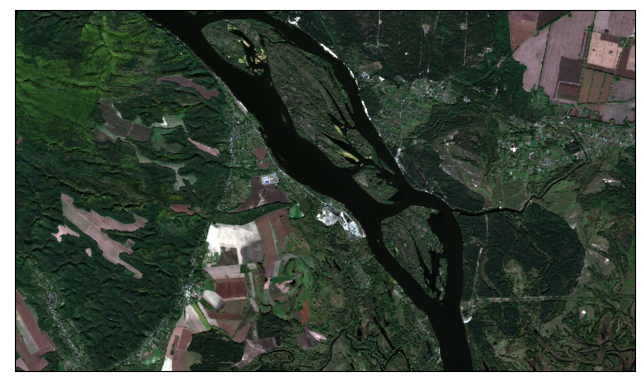

In [65]:
ep.plot_rgb(
    arr_st2,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

In [66]:
tst_img = flattenTestImage(l2)
tst_img_np = np.asarray(tst_img)
tst_img_np.shape
tst_img_np = np.moveaxis(tst_img_np, -1, 0)

In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled2 = scaler.fit_transform(tst_img_np)

In [68]:
test_image_predict_1 = knn_1.predict(X_scaled2)

In [70]:
mnb_predict_test_1 = mnb_1.predict(X_scaled2)

In [142]:
svm_predict_test_1 = svm.predict(X_scaled2)

(638, 1094, 3)


/tmp/ipykernel_11/2030408581.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  colorbar = fig.colorbar(im1, ticks=values)


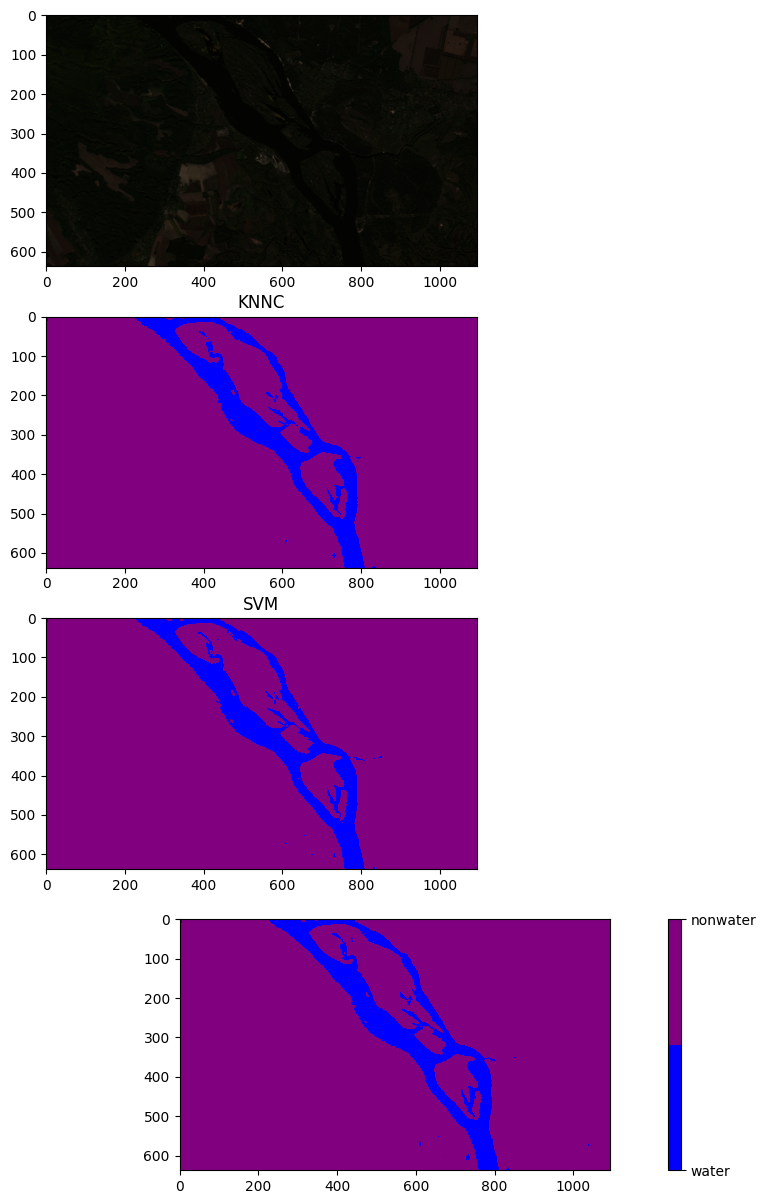

In [143]:
from PIL import Image

knn_image_default_1 = test_image_predict_1.reshape(arr_st2[0].shape)
mnb_image_default_1 = mnb_predict_test_1.reshape(arr_st2[0].shape)
svm_image_default_1 = svm_predict_test_1.reshape(arr_st2[0].shape)


fig, ax = plt.subplots(4,figsize=(15, 15))

im2_to_show = arr_st2[[3,2,1], :,:]
im2_to_show2 = np.moveaxis(im2_to_show, 0,-1)

print(im2_to_show2.shape)

im2 = ax[0].imshow(im2_to_show2)

im1 = ax[1].imshow(knn_image_default_1,cmap=ListedColormap(['blue', 'purple']))
im3 = ax[2].imshow(mnb_image_default_1,cmap=ListedColormap(['blue', 'purple']))
im4 = ax[3].imshow(svm_image_default_1,cmap=ListedColormap(['blue', 'purple']))
labels = list(['water' , 'nonwater'])
values = list([1,2])
ax[1].set_title("KNNC")
ax[2].set_title("Naive bayes")
ax[2].set_title("SVM")
# Create a colorbar with the legend
colorbar = fig.colorbar(im1, ticks=values)
colorbar.ax.set_yticklabels(labels)
plt.show()

### Detect forests

In [72]:
y_water_idx = np.where(test_image_predict_1 == 1)[0]

In [73]:
print(f"Water size is {y_water_idx.shape}")

Water size is (58662,)


In [91]:
y_water_idx_mnb = np.where(mnb_predict_test_1 == 1)[0]

In [157]:
y_water_idx_svm = np.where(svm_predict_test_1 == 1)[0]

In [74]:
x_scaled_wo_water = X_scaled2.copy()
y_water = test_image_predict_1[test_image_predict_1 == 1]

In [75]:
print(f"Size before remove water {test_image_predict_1.shape[0]} after {x_scaled_wo_water.shape[0]} and diff {test_image_predict_1.shape[0]-x_scaled_wo_water.shape[0]}")

Size before remove water 697972 after 697972 and diff 0


In [76]:
# for idx in y_water_idx:
#     np.delete(x_scaled_wo_water, idx)
x_scaled_wo_water = np.delete(x_scaled_wo_water, y_water_idx, axis=0)

In [92]:
x_scaled_wo_water_mnb = X_scaled2.copy()

In [94]:
y_water_mnb = mnb_predict_test_1[mnb_predict_test_1 == 1]
x_scaled_wo_water_mnb = np.delete(x_scaled_wo_water_mnb, y_water_idx_mnb, axis=0)

In [158]:
x_scaled_wo_water_svm = X_scaled2.copy()

In [159]:
y_water_svm = svm_predict_test_1[svm_predict_test_1 == 1]
x_scaled_wo_water_svm = np.delete(x_scaled_wo_water_svm, y_water_idx_svm, axis=0)

In [77]:
x_scaled_wo_water.shape

(639310, 12)

In [85]:
test_image_predict_2 = knn_2.predict(x_scaled_wo_water)

In [95]:
mnb_predict_test_2 = mnb_2.predict(x_scaled_wo_water_mnb)

In [160]:
svm_predict_test_2 = svm_2.predict(x_scaled_wo_water_svm)

In [643]:
#test_image_predict_2 = mnb_2.predict(x_scaled_wo_water)

In [636]:
def split_two_arrays(length, lst):
    l = []
    r = []
    for i in range(length):
        if i in lst:
            l.append(i)
        else:
            r.append(i)

    return (l,r)


In [425]:
idxs_2 = split_two_arrays(x_scaled.shape[0], y_water_idx)

In [426]:
# arr = np.arange(length)
#     mask = np.isin(arr, lst)
#     l = arr[mask]
#     r = arr[~mask]
#     return l, r

In [79]:
test_image_predict_2[test_image_predict_2 == 2] = 3
test_image_predict_2[test_image_predict_2 == 1] = 2

In [96]:
mnb_predict_test_2[mnb_predict_test_2 == 2] = 3
mnb_predict_test_2[mnb_predict_test_2 == 1] = 2

In [162]:
svm_predict_test_2[svm_predict_test_2 == 2] = 3
svm_predict_test_2[svm_predict_test_2 == 1] = 2

In [80]:
len(test_image_predict_2[test_image_predict_2 == 2])

189910

In [81]:
p = []
iter = 0
w_iter = 0
for i in range(X_scaled2.shape[0]):
    if (i in y_water_idx):
        p.append(y_water[w_iter])
        w_iter+=1
    else:
        p.append(test_image_predict_2[iter])
        iter+=1


In [98]:
mnb_test_2_composite_list = []
iter = 0
w_iter = 0
for i in range(X_scaled2.shape[0]):
    if (i in y_water_idx_mnb):
        mnb_test_2_composite_list.append(y_water_mnb[w_iter])
        w_iter+=1
    else:
        mnb_test_2_composite_list.append(mnb_predict_test_2[iter])
        iter+=1

In [164]:
svm_test_2_composite_list = []
iter = 0
w_iter = 0
for i in range(X_scaled2.shape[0]):
    if (i in y_water_idx_svm):
        svm_test_2_composite_list.append(y_water_svm[w_iter])
        w_iter+=1
    else:
        svm_test_2_composite_list.append(svm_predict_test_2[iter])
        iter+=1

In [82]:
knn_compoiste_2 = np.asarray(p)

In [100]:
mnb_compoiste_2 = np.asarray(mnb_test_2_composite_list)

In [165]:
svm_compoiste_2 = np.asarray(svm_test_2_composite_list)

(638, 1094, 3)


/tmp/ipykernel_11/2813271827.py:25: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  colorbar = fig.colorbar(im1, ticks=values)


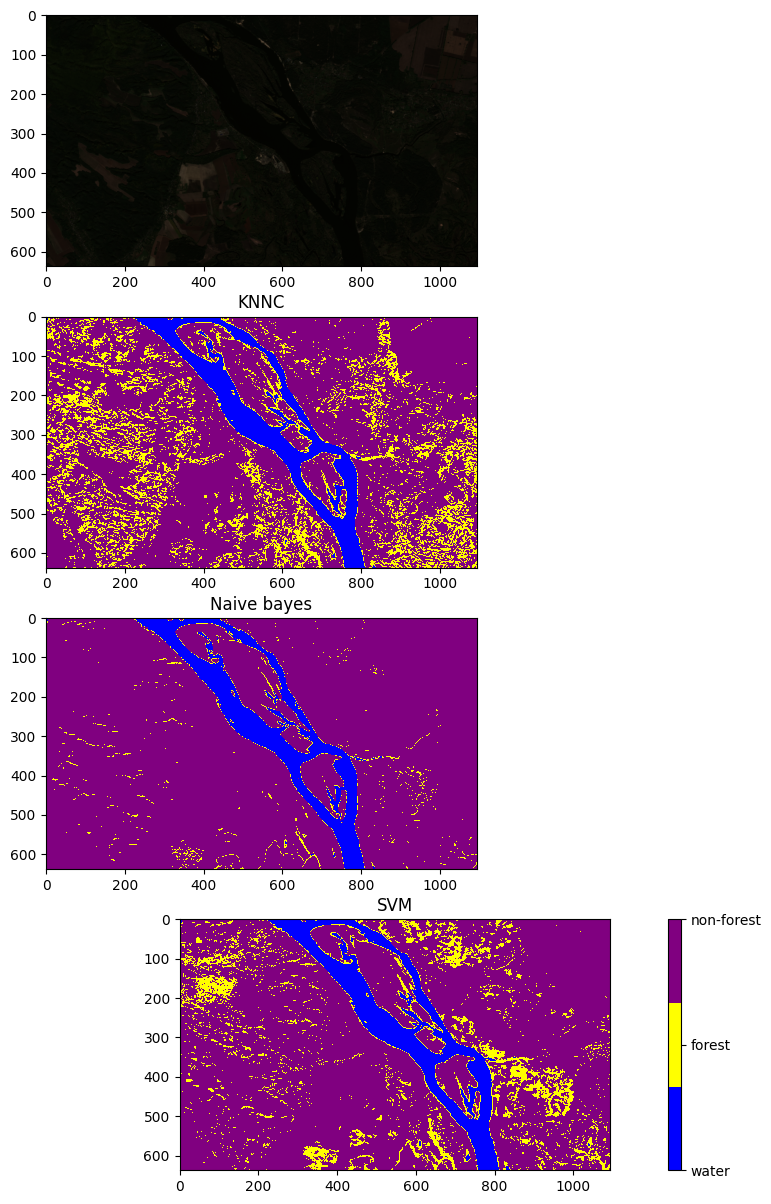

In [167]:
knn_image_default_2 = knn_compoiste_2.reshape(arr_st2[0].shape)
mnb_image_default_2 = mnb_compoiste_2.reshape(arr_st2[0].shape)
svm_image_default_2 = svm_compoiste_2.reshape(arr_st2[0].shape)


fig, ax = plt.subplots(4,figsize=(15, 15))

im2_to_show = arr_st2[[3,2,1], :,:]
im2_to_show2 = np.moveaxis(im2_to_show, 0,-1)

print(im2_to_show2.shape)

im2 = ax[0].imshow(im2_to_show2)

im1 = ax[1].imshow(knn_image_default_2,cmap=ListedColormap(['blue', 'yellow', 'purple']))
im3 = ax[2].imshow(mnb_image_default_2,cmap=ListedColormap(['blue', 'yellow', 'purple']))
im4 = ax[3].imshow(svm_image_default_2,cmap=ListedColormap(['blue', 'yellow', 'purple']))
labels = list(['water', 'forest', 'non-forest'])
values = list([1,2,3])
ax[1].set_title("KNNC")
ax[2].set_title("Naive bayes")
ax[3].set_title("SVM")

# Create a colorbar with the legend
colorbar = fig.colorbar(im1, ticks=values)
colorbar.ax.set_yticklabels(labels)
plt.show()

### Detect field non-field

In [110]:
y_forest_idx = np.where(knn_compoiste_2 == categories_map["forest"])[0]

In [111]:
y_forest = knn_compoiste_2[knn_compoiste_2 == categories_map["forest"]]

In [112]:
y_forest_idx_mnb = np.where(mnb_compoiste_2 == categories_map["forest"])[0]
y_forest_mnb = mnb_compoiste_2[mnb_compoiste_2 == categories_map["forest"]]

In [168]:
y_forest_idx_svm = np.where(svm_compoiste_2 == categories_map["forest"])[0]
y_forest_svm = mnb_compoiste_2[svm_compoiste_2 == categories_map["forest"]]

In [169]:
x_predict_3 = X_scaled2.copy()
x_predict_3_mnb = X_scaled2.copy()
x_predict_3_svm = X_scaled2.copy()

In [170]:
idx_to_remove = np.concatenate([y_forest_idx, y_water_idx])
x_predict_3 = np.delete(x_predict_3, idx_to_remove, axis=0)

idx_to_remove_mnb = np.concatenate([y_forest_idx_mnb, y_water_idx_mnb])
x_predict_3_mnb = np.delete(x_predict_3_mnb, idx_to_remove_mnb, axis=0)

idx_to_remove_svm = np.concatenate([y_forest_idx_svm, y_water_idx_svm])
x_predict_3_svm = np.delete(x_predict_3_svm, idx_to_remove_svm, axis=0)
# x_predict_3 = np.delete(x_predict_3, y_water_idx, axis=0)

In [115]:
test_image_predict_3 = knn_3.predict(x_predict_3)

In [116]:
test_image_predict_3_mnb = mnb_3.predict(x_predict_3_mnb)

In [171]:
test_image_predict_3_svm = svm_3.predict(x_predict_3_svm)

In [703]:
len(test_image_predict_3[test_image_predict_3==2])

141448

In [117]:
test_image_predict_3[test_image_predict_3 == 1] = 3
test_image_predict_3[test_image_predict_3 == 2] = 4

In [118]:
test_image_predict_3_mnb[test_image_predict_3_mnb == 1] = 3
test_image_predict_3_mnb[test_image_predict_3_mnb == 2] = 4

In [172]:
test_image_predict_3_svm[test_image_predict_3_svm == 1] = 3
test_image_predict_3_svm[test_image_predict_3_svm == 2] = 4

In [119]:
p2 = []
iter = 0
w_iter = 0
f_iter = 0
for i in range(X_scaled2.shape[0]):
    if i in y_water_idx:
        p2.append(y_water[w_iter])
        w_iter+=1
    elif i in y_forest_idx:
        p2.append(y_forest[f_iter])
        f_iter+=1
    else :
        p2.append(test_image_predict_3[iter])
        iter+=1

In [126]:
knn_compoiste_3 = np.asarray(p2)

In [120]:
p2_mnb = []
iter = 0
w_iter = 0
f_iter = 0
for i in range(X_scaled2.shape[0]):
    if i in y_water_idx_mnb:
        p2_mnb.append(y_water_mnb[w_iter])
        w_iter+=1
    elif i in y_forest_idx_mnb:
        p2_mnb.append(y_forest_mnb[f_iter])
        f_iter+=1
    else :
        p2_mnb.append(test_image_predict_3_mnb[iter])
        iter+=1

In [123]:
mnb_compoiste_3 = np.asarray(p2_mnb)

In [173]:
p2_svm = []
iter = 0
w_iter = 0
f_iter = 0
for i in range(X_scaled2.shape[0]):
    if i in y_water_idx_svm:
        p2_svm.append(y_water_svm[w_iter])
        w_iter+=1
    elif i in y_forest_idx_svm:
        p2_svm.append(y_forest_svm[f_iter])
        f_iter+=1
    else :
        p2_svm.append(test_image_predict_3_svm[iter])
        iter+=1

In [174]:
svm_compoiste_3 = np.asarray(p2_svm)

(638, 1094, 3)


/tmp/ipykernel_11/1995549781.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  colorbar = fig.colorbar(im1, ticks=values)


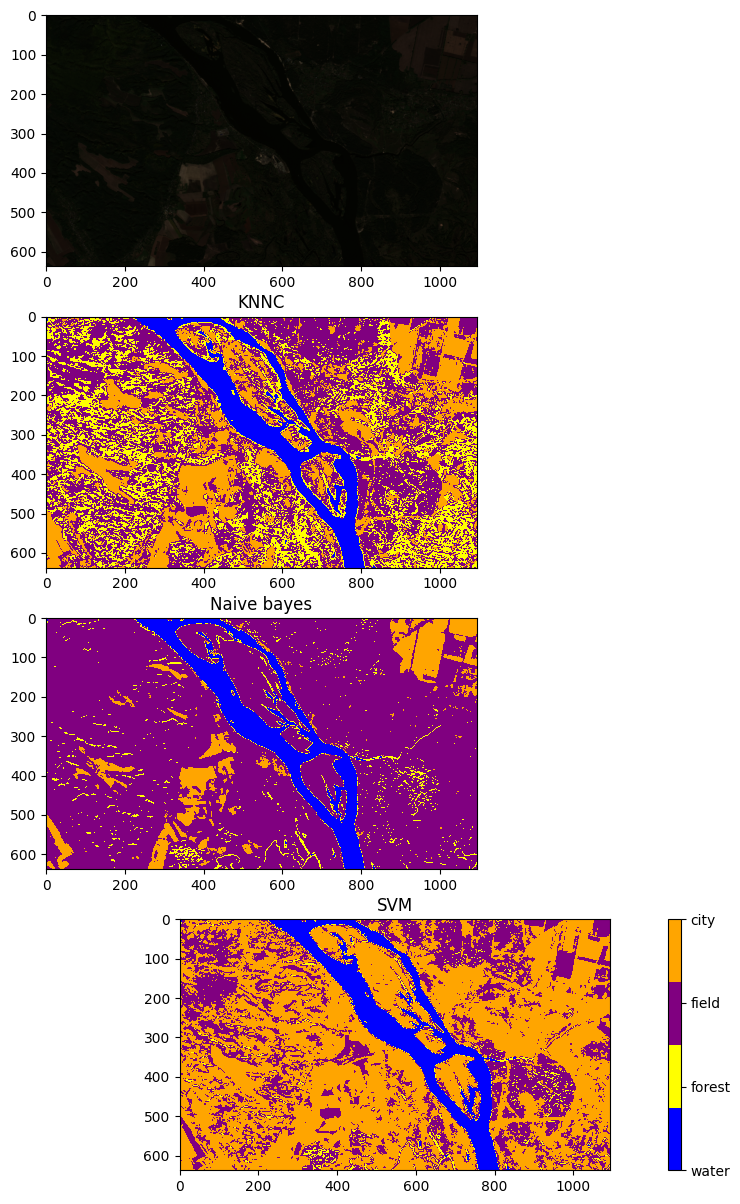

In [175]:
knn_image_default_2 = knn_compoiste_3.reshape(arr_st2[0].shape)
mnb_image_default_2 = mnb_compoiste_3.reshape(arr_st2[0].shape)
svm_image_default_2 = svm_compoiste_3.reshape(arr_st2[0].shape)

fig, ax = plt.subplots(4,figsize=(15, 15))

im2_to_show = arr_st2[[3,2,1], :,:]
im2_to_show2 = np.moveaxis(im2_to_show, 0,-1)

print(im2_to_show2.shape)

im2 = ax[0].imshow(im2_to_show2)

im1 = ax[1].imshow(knn_image_default_2,cmap=ListedColormap(['blue', 'yellow', 'purple', 'orange']))
im3 = ax[2].imshow(mnb_image_default_2,cmap=ListedColormap(['blue', 'yellow', 'purple', 'orange']))
im4 = ax[3].imshow(svm_image_default_2,cmap=ListedColormap(['blue', 'yellow', 'purple', 'orange']))

ax[1].set_title("KNNC")
ax[2].set_title("Naive bayes")
ax[3].set_title("SVM")

labels = list(['water', 'forest', 'field', 'city'])
values = list([1,2,3,4])

# Create a colorbar with the legend
colorbar = fig.colorbar(im1, ticks=values)
colorbar.ax.set_yticklabels(labels)
plt.show()

In [711]:
cuml.raft.get_mem_info().total

NameError: name 'cuml' is not defined